In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool
import json
from source import *
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

import scienceplots

plt.style.use(['science','ieee', 'grid'])

In [2]:
all_files = list(Path("gen_data/").glob("bsbs*.parquet")) + \
            list(Path("gen_data/").glob("nonbsbs*.parquet")) + \
            list(Path("gen_data/").glob("uds*.parquet"))

data = ds.dataset(all_files, format="parquet")

In [3]:
scanner = data.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    display(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__', 'pcm',
       'ecm', 'missedE', 'recM2_Ups', 'pmiss', 'cmpmiss', 'thetamiss',
       'cmthetamiss', 'fox', 'asymmetry', 'p0', 'theta_Bs', 'M0', 'recM2_Bs',
       'idec0', 'idec1', 'is0', 'N_KL', 'Miss_id_0', 'Miss_id_1', 'Bs_lik',
       'N_KS', 'theta_tau_0', 'p_tau_0', 'theta_tau_1', 'p_tau_1', 'tau_d_0_0',
       'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0', 'tau_last_z_1',
       'tau_last_r_1', 'Istau0', 'Istau1', 'Chi_sq_0', 'Chi_sq_1', 'dr0',
       'dr1', 'totalEnergyMC', 'E_gamma_in_ROE', 'correct_nu_0',
       'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1', 'lost_0',
       'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1',
       'PID_self_vs_1_tau1', 'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')

In [4]:
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012)
mask_M = (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask1 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 1) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask0 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 0) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387)
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))
mask_miss_id = pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_lost_Kpi = pc.field("lost_0") & pc.field("lost_1")
mask_KS_veto = (pc.field("N_KS") == 0) & (pc.field("N_KL") == 0)

In [5]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_11968\1033810642.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [6]:
import json
with open("output/columns_and_fom.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [7]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))

In [8]:
BS0 = 5.366691

In [9]:
wbin_x, a_x, b_x = 0.2, 0, 1.2
wbin_y, a_y, b_y = 0.01*4, 5.25, 5.5
bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y))

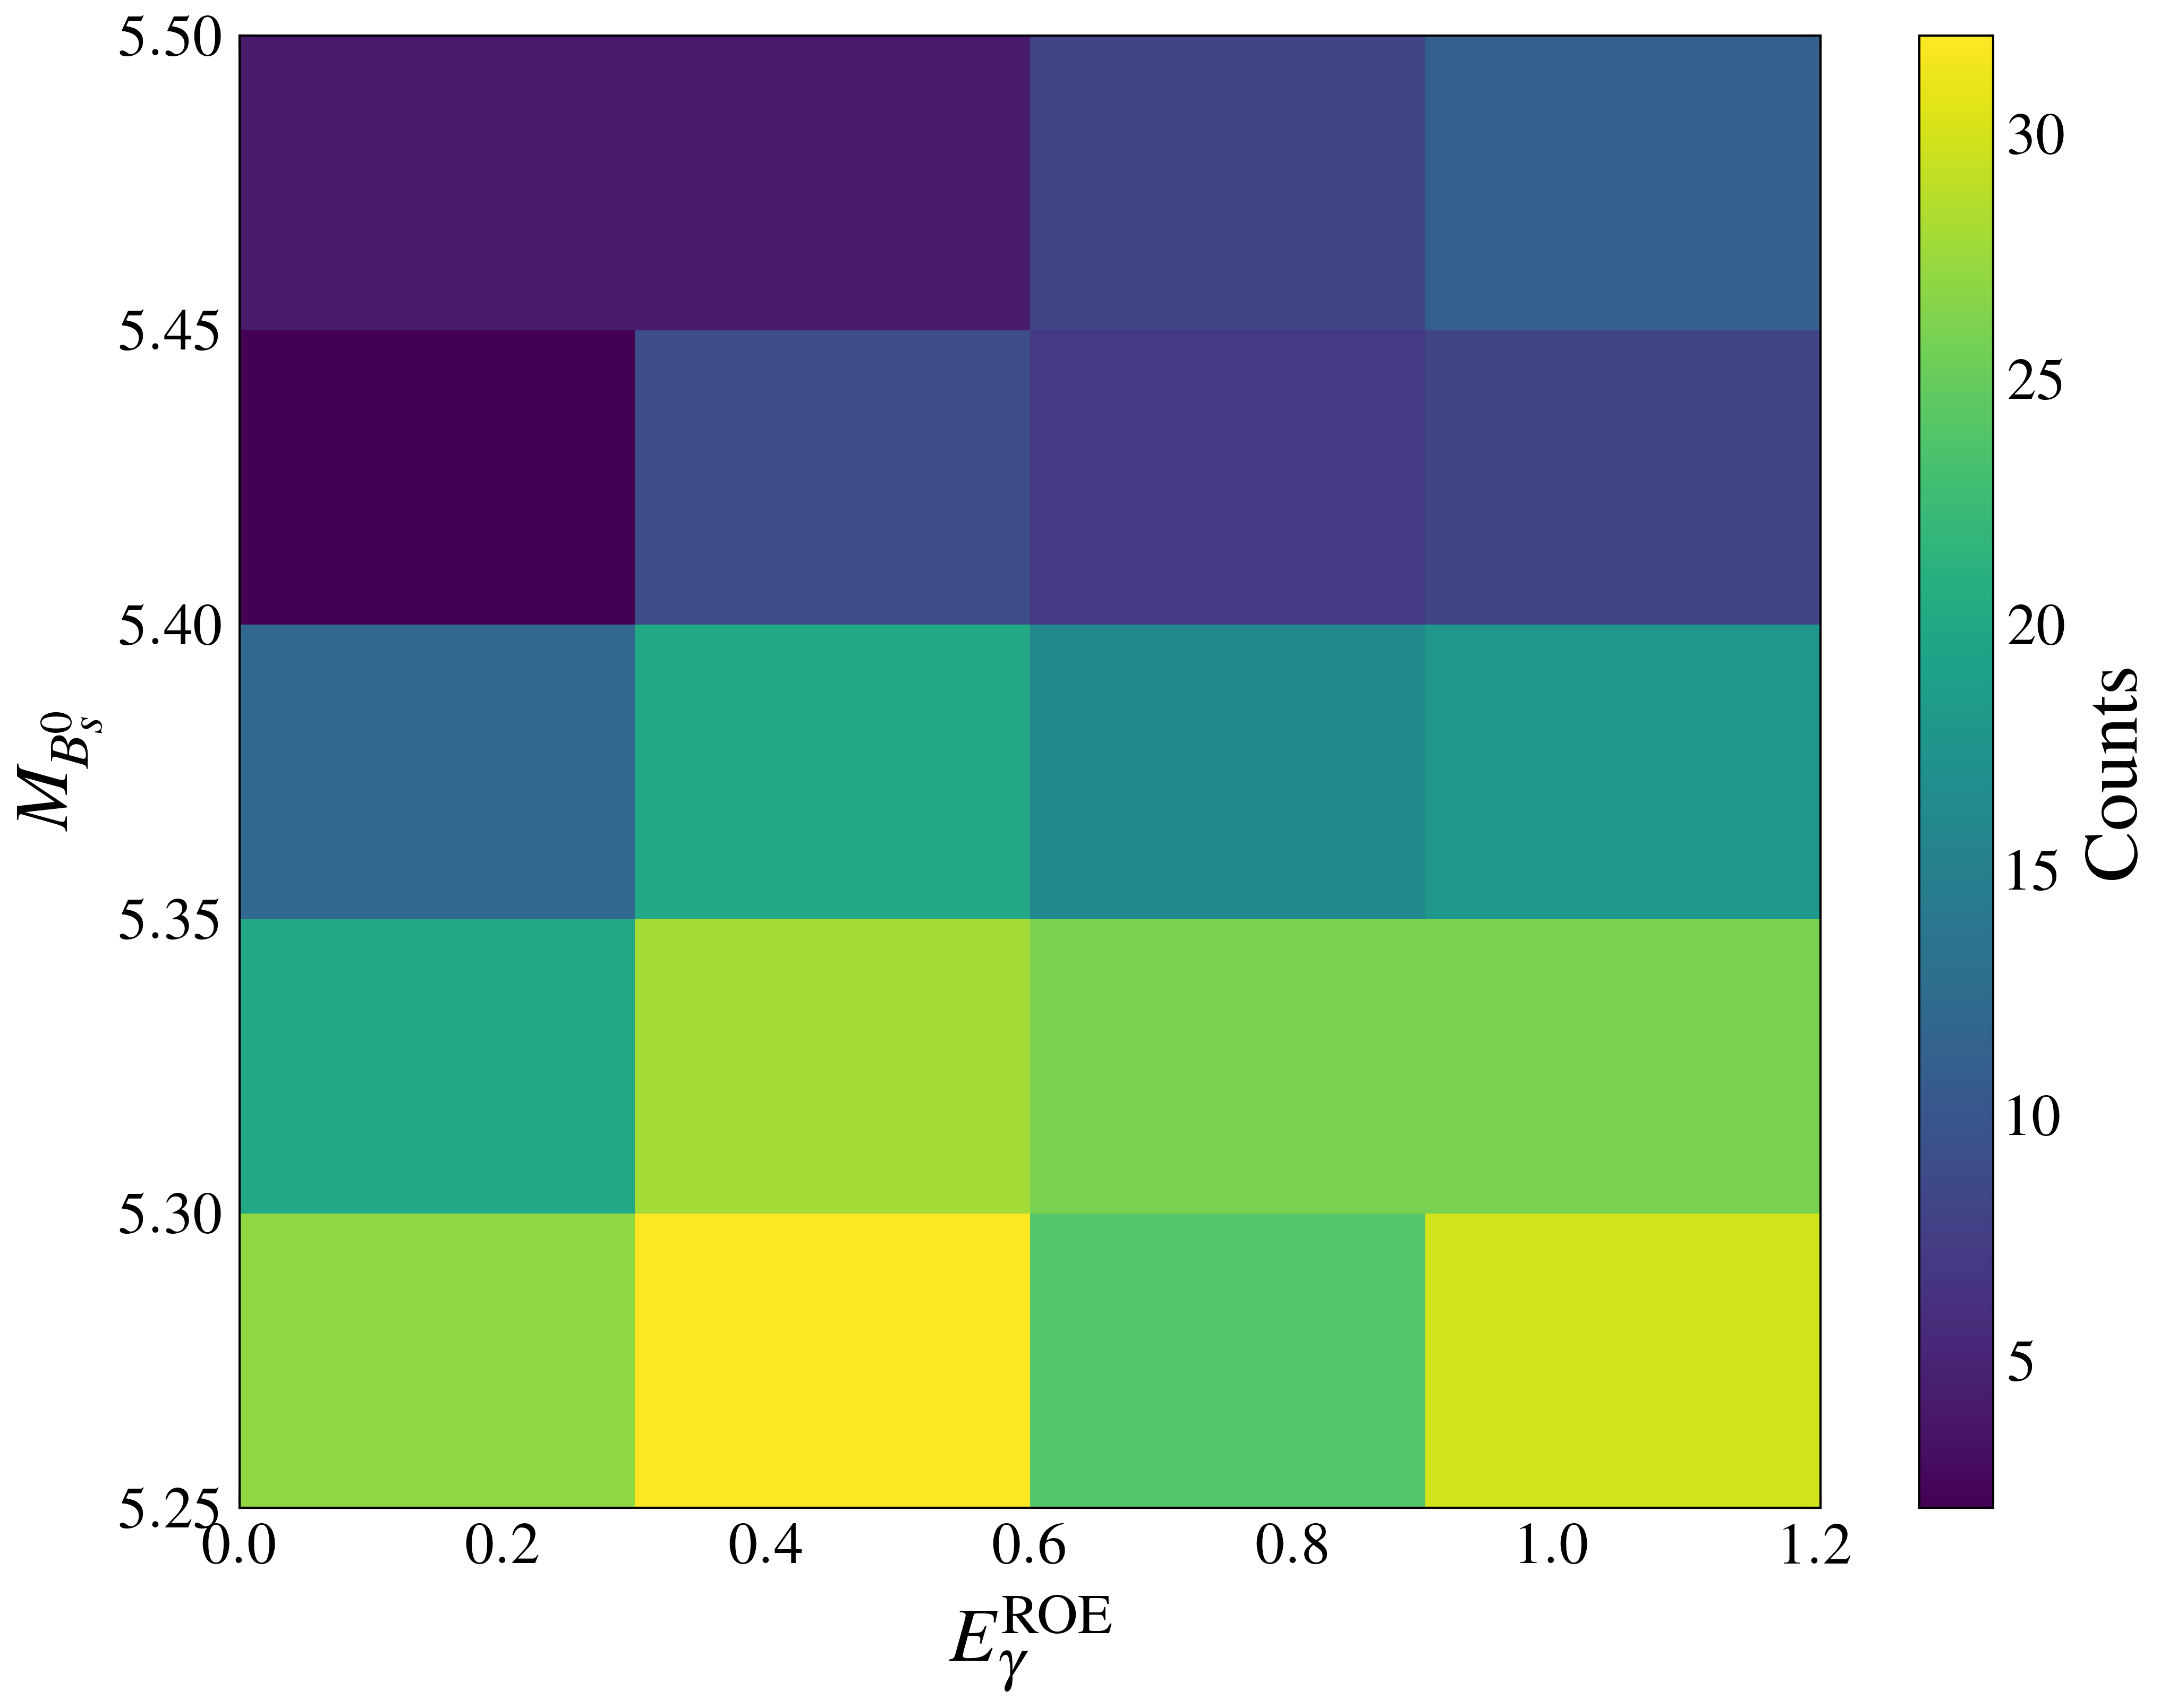

In [10]:

bin_centers, counts, N = compute_nd_histogram(data, [bins_x, bins_y], ["E_gamma_in_ROE", "M0"], filter_mask = mask & mask_lep & (pc.field("is0") == 0))

plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(*bin_centers, counts)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel(r"$M_{B_s^0}$")
plt.colorbar(pmesh, label="Counts")
plt.show()

In [11]:
hist = hist_approx()
hist.put_hist(bin_centers, counts)

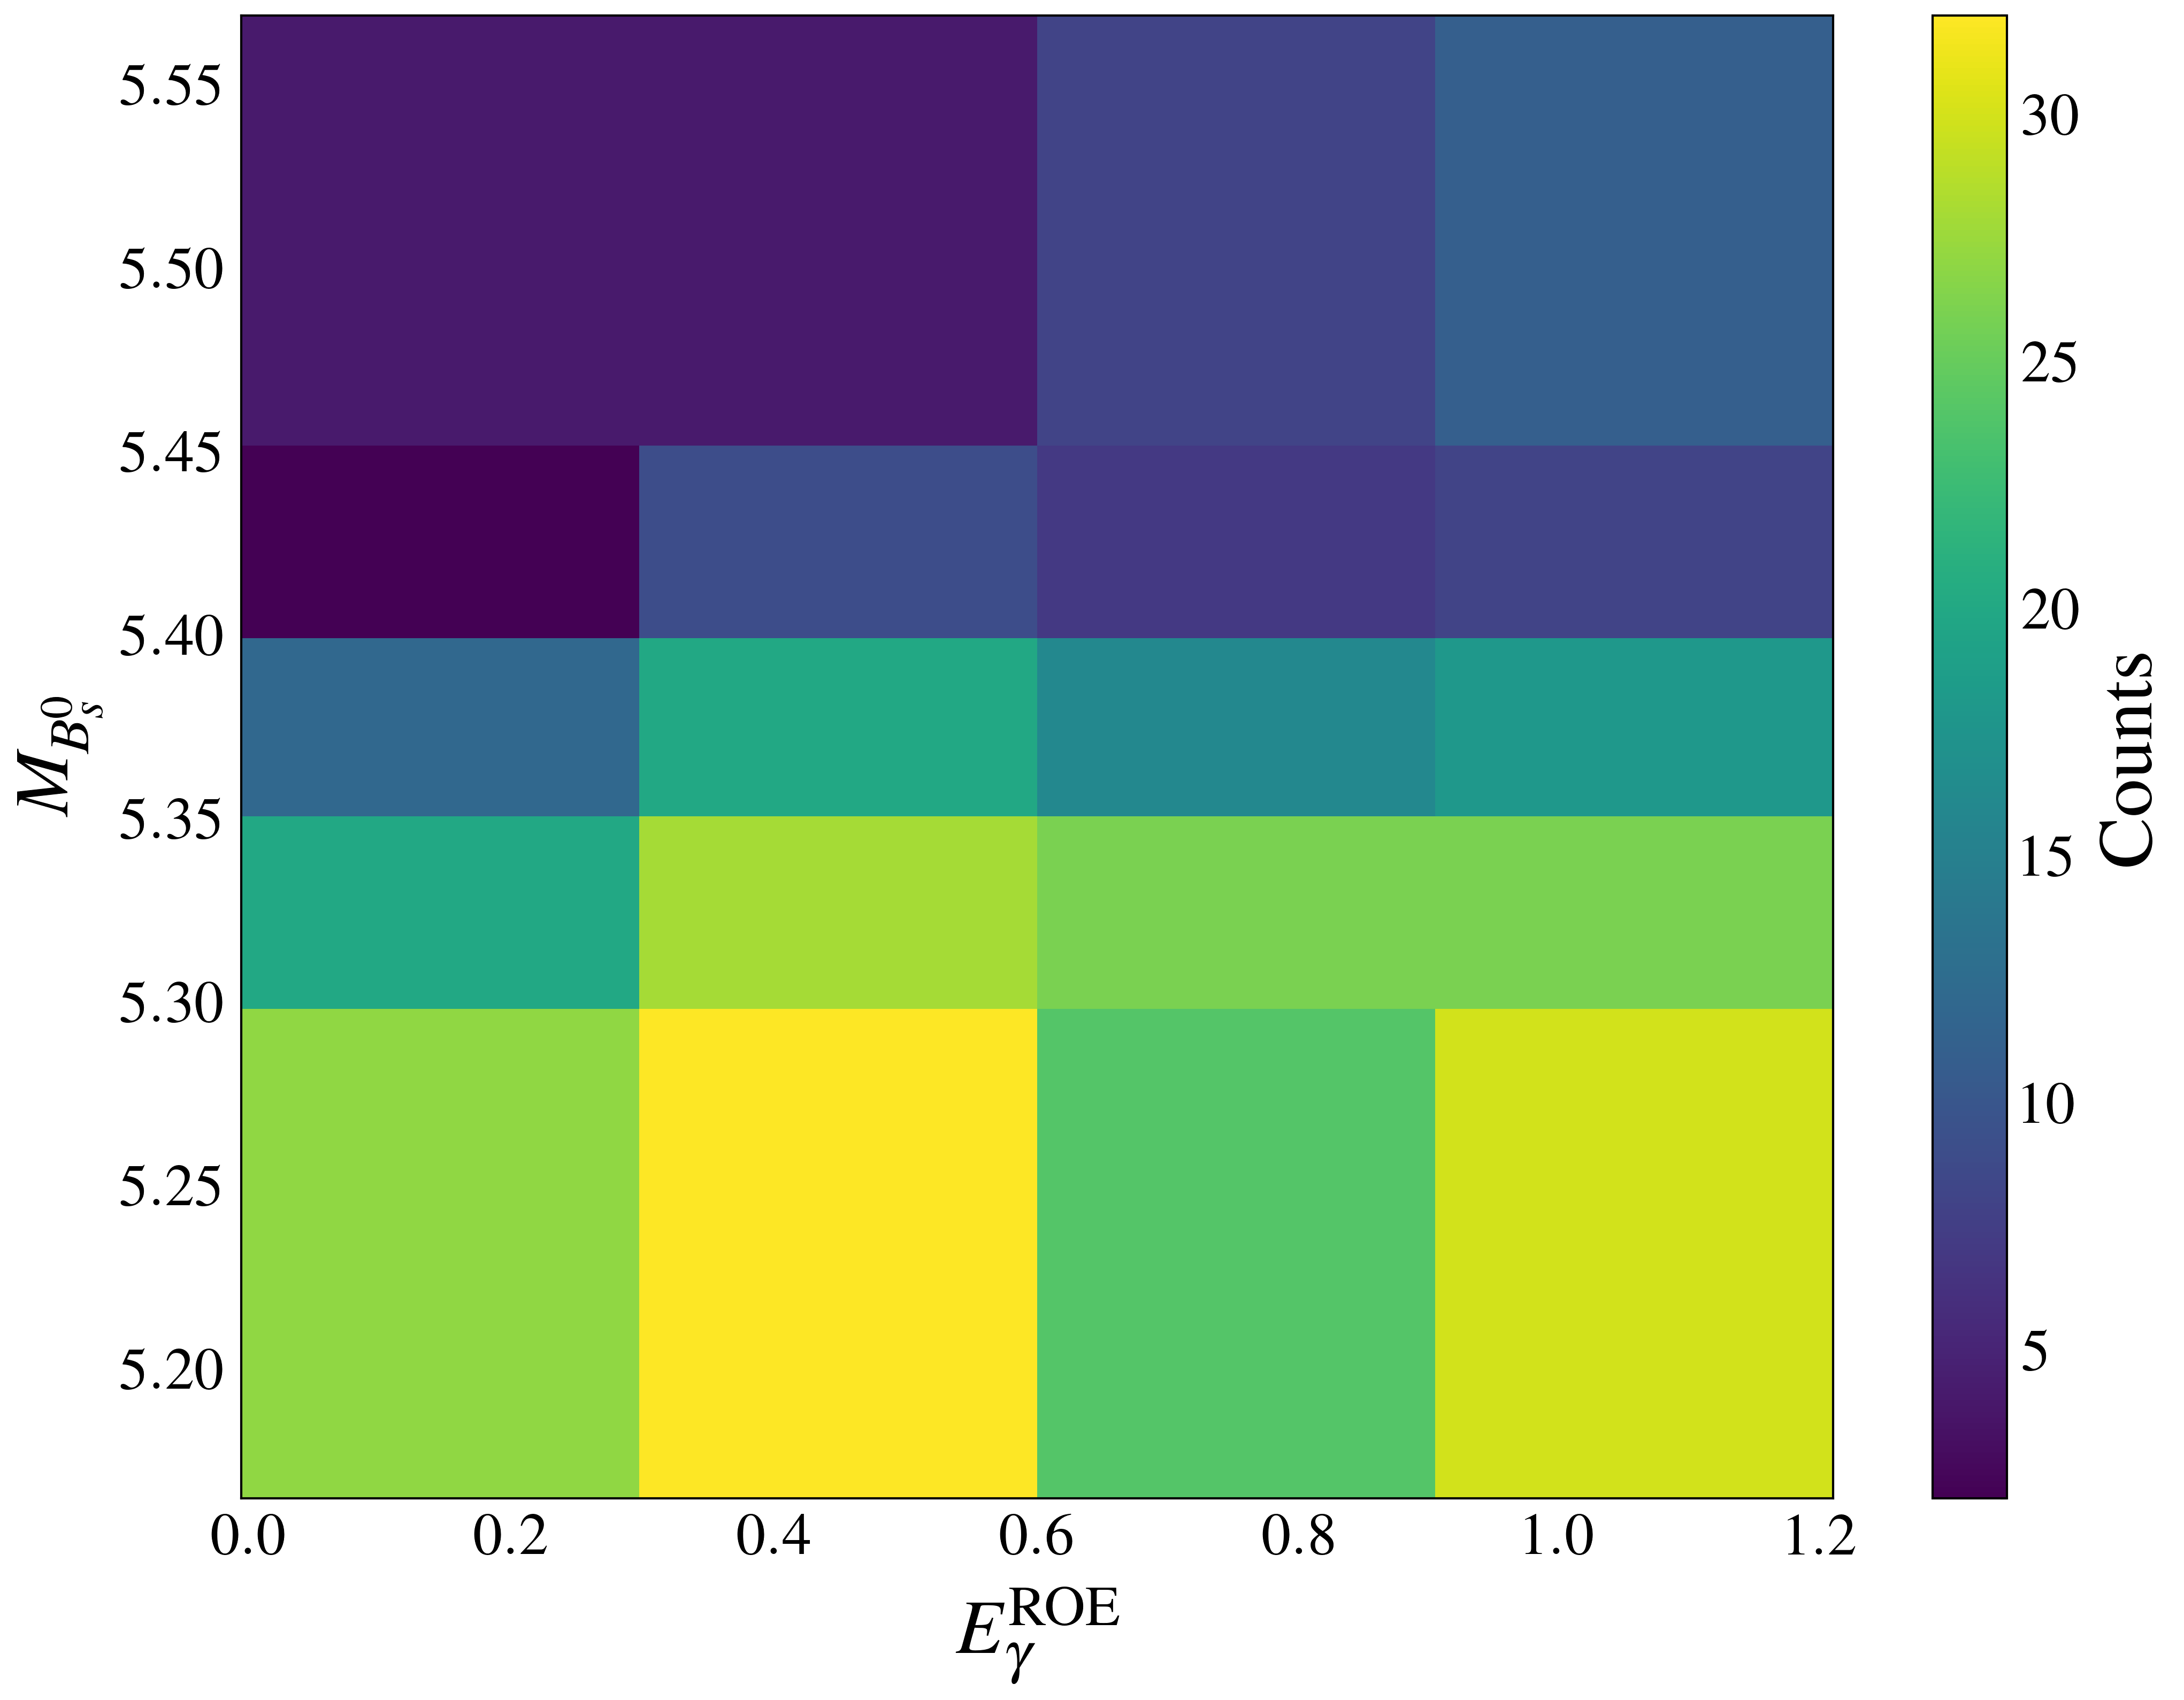

In [12]:
x = np.linspace(0, 1.2, 100)
y = np.linspace(BS0 - 0.2, BS0 + 0.2, 100)
X, Y = np.meshgrid(x, y, indexing='ij')
val = hist.get_counts([X,Y])

plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(X, Y, val)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel(r"$M_{B_s^0}$")
plt.colorbar(pmesh, label="Counts")
plt.show()

In [13]:
hist.save_hist("output/ubs.json")